In [1]:
from mizani.formatters import scientific_format
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import numpy as np
import pandas as pd
from plotnine import *
import scipy.stats
import skmisc
import sys

from dataclasses import dataclass
from datetime import datetime
from datetime import timedelta
from typing import Dict, List, Optional, Tuple
from pandas.core.frame import DataFrame

# read in custom modules
sys.path.append('/Users/rosekantor/work/wbe_data_analysis/')
from wbe.read_gsheets import *
from wbe.process_qpcr import *
from wbe.calculations import *
from wbe.qa_qc import *
from wbe.quality_score import *

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Run pipeline (analysis and merging tables)

## 1. Load data

In [2]:
# from csv
datadir = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe'

sites = f'{datadir}/site_lookup_060321.csv'
samples = f'{datadir}/sample_inventory_060321.csv'
qpcr = f'{datadir}/QuantStudio_raw_data_060321.csv'
plates = f'{datadir}/Plate_info_060321.csv'
sample_log = f'{datadir}/Sample_collection_log_052721.csv'
sample_metadata = f'{datadir}/Sample_metadata_052721.csv'

# sites = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_050521.csv'
# samples = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/sample_inventory_050521.csv'
# qpcr = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/QuantStudio_raw_data_050521.csv'
# plates = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Plate_info_050521.csv'
# sample_log = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Sample_collection_log_050521.csv'
# sample_metadata = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Sample_metadata_050521.csv'

sampling_df = read_sample_logs(None, None, None, sample_log, sample_metadata)
extraction_df = read_sample_data(None, None, samples, sites)
qpcr_plate_df = read_plate_data(None, None, plates)
qpcr_raw_df = read_qpcr_data(None, None, qpcr)

## 2. process qPCR data

In [3]:
## remove Xeno from targets (this was an inhibition control, we no longer use)
#qpcr_raw_df = qpcr_raw_df[qpcr_raw_df.Target != 'Xeno']

## find plates that contained only standards and drop them
plates_samples = set(qpcr_raw_df[qpcr_raw_df.Task == 'Unknown'].plate_id)
plates_standards = set(qpcr_raw_df[qpcr_raw_df.Task == 'Standard'].plate_id)
plates_standards_only = plates_standards - plates_samples
qpcr_raw_df = qpcr_raw_df[~qpcr_raw_df.plate_id.isin(plates_standards_only)]

## replace all N1 and PMMoV standard curves with average curve by dropping them at this step
## code will automatically replace missing curves with hard-coded default curve
## catch standards in a separate df
plate_standards_df = qpcr_raw_df[qpcr_raw_df.Task == 'Standard']
plate_samples_df = qpcr_raw_df[qpcr_raw_df.Task != 'Standard']

## add back the bCoV curves so that each plate's standard curve is used
bcov_standards_df = plate_standards_df[plate_standards_df.Target == 'bCoV']
plate_samples_df = plate_samples_df.append(bcov_standards_df)


## process the qPCR data <- the bulk of the code happens in this step
qpcr_processed_dilutions, plate_target_info_samples = process_qpcr_plate(plate_samples_df)
qpcr_processed = choose_dilution(qpcr_processed_dilutions)
qpcr_processed = qpcr_processed[qpcr_processed.Target != 'Xeno']

# make column listing number of technical replicates detected, based on the non-detect count
qpcr_processed['detected_of_3_TechReps'] = 3 - qpcr_processed['nondetect_count']

## process just the standards (if they have been removed from the data)
with warnings.catch_warnings(): # ignore warnings that there are no NTCs, this call runs only standards
    warnings.simplefilter("ignore")
    qpcr_processed_dilutions_stds, plate_target_info_stds = process_qpcr_plate(plate_standards_df)

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice


## 3. merge tables together from qpcr and extraction

In [4]:
## 3a. merge qpcr plate info for samples and standards
### (code was designed to keep standards and samples together, but we are splitting them now to force use of default standard curves)
plate_target_info_stds = plate_target_info_stds[['num_points', 'slope', 'intercept', 'r2', 'efficiency', 'loq_Cq', 'loq_Quantity', 'plate_id', 'Target']]
plate_target_info_samples = plate_target_info_samples[['used_default_curve', 'plate_id', 'Target', 'Target_full', 'intraassay_var', 'ntc_is_neg', 'ntc_Cq']]

if not len(plate_target_info_samples) == len(plate_target_info_stds):
    warnings.warn("plate_target_info dataframes from stds and samples are different lengths")
if not set(plate_target_info_samples.plate_id) == set(plate_target_info_stds.plate_id):
    warnings.warn("not all samples plates had stds") # we already dropped plates that had stds but no samples

plate_target_info_stds_samples = plate_target_info_samples.merge(plate_target_info_stds, on=['plate_id', 'Target'], how='left')
plate_target_info_all = plate_target_info_stds_samples.merge(qpcr_plate_df, on='plate_id', how='left')
# note: qpcr_plate_df contains some plates that were tests, not all will be in plate_target_info_stds_samples

if not len(plate_target_info_all) == len(plate_target_info_stds_samples):
    warnings.warn("plate_id duplicate rows introduced") 

    
## 3b. merge sample data, qPCR data, and plate data
if set(qpcr_processed.Sample) - set(extraction_df.sample_id) != set():
    warnings.warn("samples found in qPCR data that are not in extraction data")

extraction_df_qpcr = qpcr_processed.merge(extraction_df, how = 'left', left_on = 'Sample', right_on = 'sample_id')
extraction_df_qpcr = extraction_df_qpcr.merge(plate_target_info_all, how = 'left', on = ['plate_id', 'Target'])

if not len(extraction_df_qpcr) == len(qpcr_processed):
    warnings.warn("plate target info merge resulted in new rows") # check no new rows were introduced

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: plate_target_info dataframes from stds and samples are different lengths
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: not all samples plates had stds
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: samples found in qPCR data that are not in extraction data


In [5]:
# These plates are missing standard curves
set(plate_target_info_samples.plate_id) - set(plate_target_info_stds.plate_id)

{1440, 1441}

## 4. pull out extraction controls and report them for each batch, if they exist
(should do this here or fairly early so that extraction controls are removed from the dataset)

In [6]:
before_merge_len = len(extraction_df_qpcr[extraction_df_qpcr.sample_code != 'control_control_PBS'])
extraction_df_qpcr = get_extraction_control(extraction_df_qpcr)
if not before_merge_len == len(extraction_df_qpcr):
    warnings.warn("merging extraction data resulted in a different number of rows")

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:4200: RuntimeWarning: Mean of empty slice


## 5. get bCoV recovery
(could happen any time, needed for quality_score())

In [7]:
bcov_recovery = calculate_recovery(extraction_df_qpcr, 'bCoV')

extraction_df_qpcr = extraction_df_qpcr[~extraction_df_qpcr.Sample.str.contains('control_spike_bCoV')]
before_merge_len = len(extraction_df_qpcr)
extraction_df_qpcr = extraction_df_qpcr.merge(bcov_recovery, how='left', on='Sample')
if not len(extraction_df_qpcr) == before_merge_len:
    warnings.warn("bCoV recovery merge resulted in new rows")

## 6. calculate gc/L
(can happen any time after extraction_df and qpcr_processed are merged, needed before pulling out PMMoV data below)

In [8]:
extraction_df_qpcr['gc_per_mL'] = calculate_gc_per_ml(extraction_df_qpcr)

## 7. merge master table with sample collection data
(could happen any time, entries in sampling_df needed for quality_score())

In [9]:
extraction_df_qpcr = extraction_df_qpcr.merge(sampling_df, how='left', on=['sample_code', 'date_sampling'])

## 8. pull PMMoV data out and merge onto N1 data in preparation for quality_score()
effectively shifting from longer to wider format where there is one line per sample with all attributes for that sample

In [10]:
n1_df = extraction_df_qpcr[extraction_df_qpcr.Target == 'N1']
pmmov_df = extraction_df_qpcr[extraction_df_qpcr.Target == 'PMMoV'][['Sample', 'gc_per_mL']]
pmmov_df = pmmov_df.rename(columns={'gc_per_mL': 'pmmov_gc_per_mL'})
before_merge_len = len(n1_df)
n1_df = n1_df.merge(pmmov_df, how='left', on='Sample')
if not len(n1_df) == before_merge_len:
    warnings.warn("PMMoV merge resulted in new rows")

# calculate N1 per PMMoV
n1_df['N1_per_PMMoV'] = n1_df.gc_per_mL / n1_df.pmmov_gc_per_mL

## 9. calculate quality scores and add to master table

In [11]:
quality_scores, quality_info = quality_score(n1_df)
n1_df_scored = n1_df.merge(quality_scores, how='left', on=['Sample', 'plate_id', 'Target'])
n1_df_quality_info = n1_df.merge(quality_info, how='left', on=['Sample'])
if not len(n1_df_scored) == len(n1_df):
    warnings.warn("quality score merge introduced new rows")

n1_df_scored = n1_df_scored.rename(columns={'gc_per_mL': 'SARS_CoV_2_N1_gc_per_mL'})

/Users/rosekantor/work/wbe_data_analysis/wbe/quality_score.py:111: RuntimeWarning: Mean of empty slice
/Users/rosekantor/work/wbe_data_analysis/wbe/quality_score.py:218: RuntimeWarning: Mean of empty slice


In [12]:
n1_df_scored['turnaround_time'] = (n1_df_scored.plate_date - n1_df_scored.date_sampling).dt.days
n1_df_scored.loc[n1_df_scored.turnaround_time < 0, 'turnaround_time'] = np.nan

In [13]:
# option to save final scored master table (e.g. for the dashboard)
# n1_df_scored.to_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/processed_data_thru_031121.csv', index=False)

## 10. Reshape and aggregate, prepare for plotting

In [14]:
# do some filtering and formatting
n1_df_scored = n1_df_scored[~n1_df_scored.sample_level.isin(['control', 'Effluent'])]
n1_df_scored = n1_df_scored[~n1_df_scored.sample_level.isna()]
n1_df_scored = n1_df_scored[~n1_df_scored.replicate.str.contains('sw')]
n1_df_scored.detected_of_3_TechReps = n1_df_scored.detected_of_3_TechReps.astype('category') 

# reformat wide-to-long for plotting
df_long = n1_df_scored[['site_full_name', 'utility_name', 'sample_code', 'sample_level', 'county',
                        'date_sampling', 'replicate', 'quality_score', 'detected_of_3_TechReps',
                        'SARS_CoV_2_N1_gc_per_mL', 'pmmov_gc_per_mL', 'N1_per_PMMoV']]

df_long = df_long.melt(id_vars=['site_full_name', 'utility_name', 'sample_code', 'sample_level', 'county',
                                'date_sampling', 'replicate', 'quality_score', 'detected_of_3_TechReps'],
                       value_vars=['SARS_CoV_2_N1_gc_per_mL', 'pmmov_gc_per_mL', 'N1_per_PMMoV'],
                       value_name='value',
                       var_name='measurement')

In [15]:
# aggregate data by biological replicates and calculate geometric means
df_agg = df_long.groupby(['sample_code', 'date_sampling', 'sample_level', 'county', 'site_full_name', 'utility_name', 'measurement']).agg(lambda x: x.tolist()).reset_index()
df_agg['gmean_value'] = df_agg.value.apply(lambda x: get_gmean(x))
df_agg['gstd_value'] = df_agg.value.apply(lambda x: get_gstd(x))
df_agg['gmean_value_upper'] = df_agg.gmean_value * df_agg.gstd_value
df_agg['gmean_value_lower'] = df_agg.gmean_value / df_agg.gstd_value
df_agg.measurement = pd.Categorical(df_agg.measurement,
                                      categories=['SARS_CoV_2_N1_gc_per_mL', 'pmmov_gc_per_mL', 'N1_per_PMMoV'], ordered=True) 

## 11. Save data

In [16]:
parent_dir = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures'
# parent_dir = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe'
# df.to_csv(f'{parent_dir}/full_wastewater_dataset_newformat.csv', index=False)
# df_agg.to_csv(f'{parent_dir}/full_wastewater_dataset_aggregated.csv', index=False)

# Data visualization

## Figure S1. Samples over time.

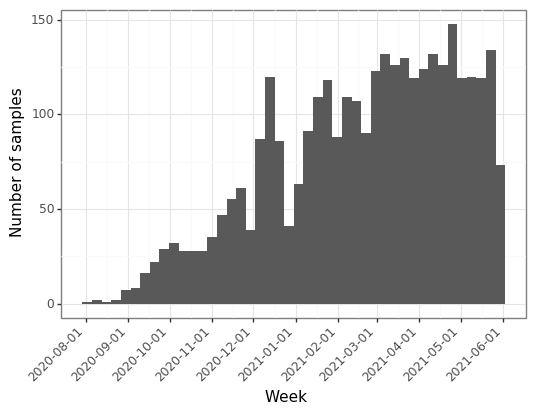

<ggplot: (308522869)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/pop-up_lab_samples_processed.png


In [17]:
#calculate number of samples processed per week (or make bar plot)
plt = (ggplot(n1_df_scored, aes(x='date_sampling'))+
 geom_histogram(binwidth=7)+
 xlab('Week')+
 ylab('Number of samples')+
 theme_bw()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(6,4))
 )
display(plt)
ggsave(plt, f'{parent_dir}/pop-up_lab_samples_processed.png')

## Figure 2. Example time series data.

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 37 rows containing missing values.


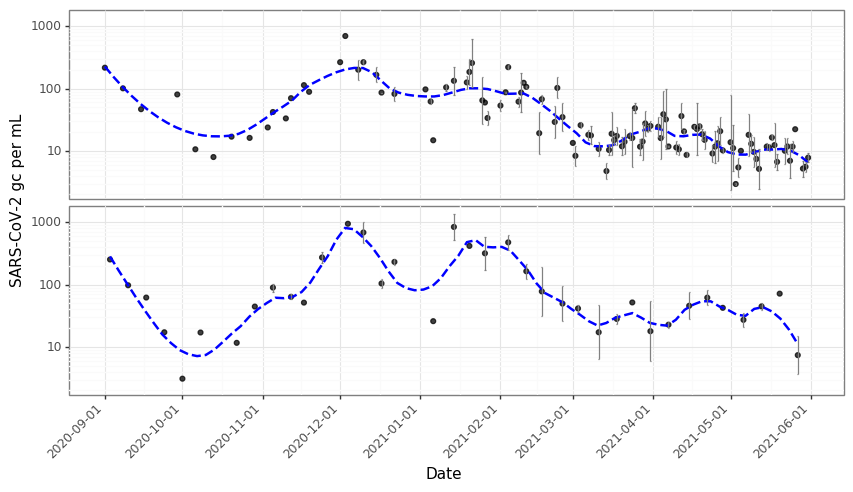

<ggplot: (306849997)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 5 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/timeseries_data_with_error.png
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 37 rows containing missing values.


In [18]:
plt = (ggplot(df_agg[(df_agg.measurement.isin(['SARS_CoV_2_N1_gc_per_mL'])) &
               (df_agg.sample_code.isin(['D_SEP_INF', 'D_SEP_NF']))],
        aes(x='date_sampling', y='gmean_value'))+
geom_point(size=1.5, alpha=0.75)+
#geom_bar(stat='identity', width=1)+
geom_smooth(method='loess', span=0.2, se=False, linetype='dashed', color='blue')+
geom_abline(slope=0, intercept=10, linetype='dashed')+
geom_errorbar(aes(ymin='gmean_value_lower', ymax='gmean_value_upper'), color='gray')+
scale_y_log10()+
xlab('Date')+
ylab('SARS-CoV-2 gc per mL')+
theme_bw()+ 
facet_grid('sample_code ~ ')+#, scales='free', space='free'
theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(10,5), strip_text_y=element_blank()))
display(plt)
ggsave(plt, f'{parent_dir}/timeseries_data_with_error.png')

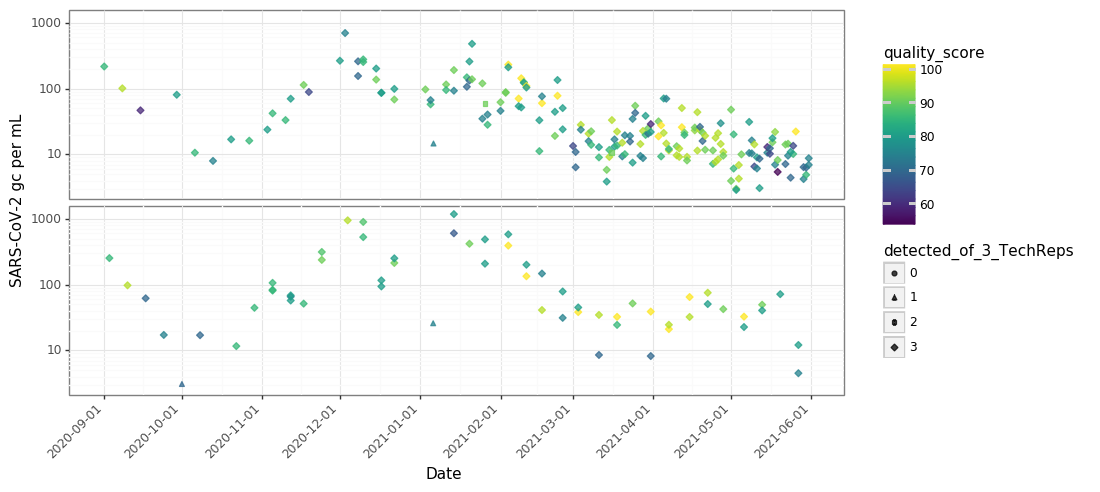

<ggplot: (306838061)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 5 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/timeseries_data_with_quality.png


In [19]:
plt = (ggplot(df_long[(df_long.measurement.isin(['SARS_CoV_2_N1_gc_per_mL'])) &
               (df_long.sample_code.isin(['D_SEP_INF', 'D_SEP_NF']))],
        aes(x='date_sampling', y='value', color='quality_score', shape='detected_of_3_TechReps'))+
geom_point(size=1.5, alpha=0.75)+
#geom_bar(stat='identity', width=1)+
#geom_smooth(method='loess', span=0.2, se=False, linetype='dashed', color='blue')+
geom_abline(slope=0, intercept=10, linetype='dashed')+
scale_y_log10()+
xlab('Date')+
ylab('SARS-CoV-2 gc per mL')+
theme_bw()+ 
facet_grid('sample_code ~ ')+#, scales='free', space='free'
theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(10,5), strip_text_y=element_blank()))
display(plt)
ggsave(plt, f'{parent_dir}/timeseries_data_with_quality.png')

## Figure S2. Quality over time.

In [20]:
df = n1_df_scored.copy()
df['date_sampling_minus7'] = pd.to_datetime(df['date_sampling']) - pd.to_timedelta(7, unit='d')
# average data by week for each location

## GET N1 DATAFRAME COLLAPSED BY WEEK
df_week_qc = df.groupby(pd.Grouper(key='date_sampling_minus7', freq='W-MON')).agg(mean_quality_score=('quality_score', 'mean'),
                                    std_quality_score=('quality_score', 'std'),
                                    quality_score_count=('quality_score', 'count'),
                                    mean_turnaround_time=('turnaround_time', 'mean'),
                                    sample_count=('SARS_CoV_2_N1_gc_per_mL', 'count')
                                    ).reset_index()

#df_week_qc['week2'] = df_week_qc.week.apply(lambda x: datetime.strptime(x + '-1', "%Y-%W-%w"))
df_week_qc['upper_error'] = df_week_qc.mean_quality_score + (df_week_qc.std_quality_score / np.sqrt(df_week_qc.quality_score_count))
df_week_qc['lower_error'] = df_week_qc.mean_quality_score - (df_week_qc.std_quality_score / np.sqrt(df_week_qc.quality_score_count))

In [21]:
df_week_qc.head()

,date_sampling_minus7,mean_quality_score,std_quality_score,quality_score_count,mean_turnaround_time,sample_count,upper_error,lower_error
0,2020-08-03,65.0,0.000000,2,48.000000,1,65.000000,65.000000
1,2020-08-10,57.5,3.535534,2,41.000000,1,60.000000,55.000000
2,2020-08-17,65.0,NaN,1,NaN,0,NaN,NaN
3,2020-08-24,67.5,10.606602,2,27.000000,1,75.000000,60.000000
4,2020-08-31,77.0,11.832160,10,19.555556,9,80.741657,73.258343


/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.


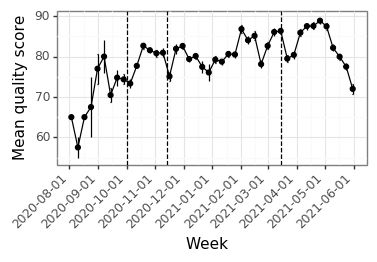

<ggplot: (308511173)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/quality_score_mean_over_time.png
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.


In [22]:
#calculate number of samples processed per week (or make bar plot)
plt = (ggplot(df_week_qc, aes(x='date_sampling_minus7', y='mean_quality_score'))+
 geom_point()+
 geom_line()+
 geom_errorbar(aes(ymin='lower_error', ymax='upper_error'))+
 geom_vline(xintercept=pd.to_datetime('2020-10-01'), linetype='dashed')+
 geom_vline(xintercept=pd.to_datetime('2020-11-13'), linetype='dashed')+
 geom_vline(xintercept=pd.to_datetime('2021-03-15'), linetype='dashed')+
 xlab('Week')+
 ylab('Mean quality score')+
 theme_bw()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(4,2))
 )
display(plt)
ggsave(plt, f'{parent_dir}/quality_score_mean_over_time.png')

#Vertical lines at October 1, 2020, November 13, 2020, and March 15, 2021, respectively indicate the official launch of the monitoring lab, the inclusion of 5-fold dilutions for inhibition in every N1 assay, and the analysis of multiplexed PMMoV and BCoV on every sample.

## Figure 3. Data quality parameters heatmap.

In [23]:
quality_info_melt = quality_info.melt(id_vars='Sample')
quality_info_agg = quality_info_melt.groupby(['variable', 'value']).agg('count').reset_index()
quality_info_agg['Fraction of samples'] = np.round(quality_info_agg.Sample / len(quality_info), 2)

quality_info_agg.loc[quality_info_agg.value==0.0, 'value'] = 'Poor'
quality_info_agg.loc[quality_info_agg.value==0.5, 'value'] = 'Acceptable'
quality_info_agg.loc[quality_info_agg.value==1.0, 'value'] = 'Good'
quality_info_agg.value = pd.Categorical(quality_info_agg.value, categories=['Poor', 'Acceptable', 'Good'], ordered=True)

quality_info_agg.variable = quality_info_agg.variable.str.replace('sample', 'Sample', regex=True)
quality_info_agg.variable = quality_info_agg.variable.str.replace('extraction', 'Extraction', regex=True)
quality_info_agg.variable = quality_info_agg.variable.str.replace('qpcr', 'RT-qPCR', regex=True)
quality_info_agg.variable = quality_info_agg.variable.str.replace('_', ' ', regex=True)

quality_info_agg.variable = pd.Categorical(quality_info_agg.variable, categories=['Sample collection',
                                                         'Sample hold time',
                                                         'Extraction neg control',
                                                         'Extraction processing error',
                                                         'Extraction recovery control',
                                                         'Extraction fecal control',
                                                         'RT-qPCR neg control',
                                                         'RT-qPCR efficiency',
                                                         'RT-qPCR num points',
                                                         'RT-qPCR stdev techreps',
                                                         'RT-qPCR inhibition'][::-1], ordered=True)

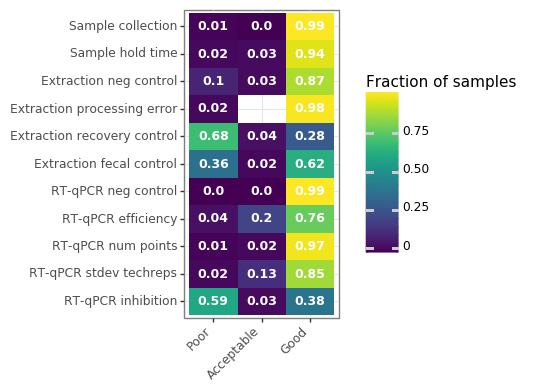

<ggplot: (308479009)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 4 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/quality_score_summary_heatmap.png


In [24]:
plt = (ggplot(quality_info_agg, aes(x='value', y='variable', fill='Fraction of samples'))+
 geom_tile()+
 geom_text(aes(label='Fraction of samples'), size=9, color='white', fontweight='bold')+
 xlab('')+
 ylab('')+
 theme_bw()+
 theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(2, 4)))

display(plt)
ggsave(plt, f'{parent_dir}/quality_score_summary_heatmap.png')

### Remake heatmap with only samples for which bcov and pmmov were both analyzed and 1x and 5x dilutions were performed

In [25]:
# add info on pmmov, bcov, and date_sampling
quality_info_and_inputs = quality_info.merge(n1_df[['Sample', 'pmmov_gc_per_mL', 'bCoV_perc_recovered', 'date_sampling']], how='left', on='Sample')

In [26]:
# filter to remove samples that are missing pmmov, bcov, or were from 
# before 11/13/2020 when we started running 5x dilutions on N1 to test for inhibition
quality_info_and_inputs = quality_info_and_inputs[~(quality_info_and_inputs.pmmov_gc_per_mL.isna()) &
                                                  ~(quality_info_and_inputs.bCoV_perc_recovered.isna()) &
                                                  (quality_info_and_inputs.date_sampling >= '2020-11-13')]

# drop these columns before melting
quality_info_and_inputs = quality_info_and_inputs.drop(columns=['pmmov_gc_per_mL', 'bCoV_perc_recovered', 'date_sampling'])
len(quality_info_and_inputs)

1015

In [27]:
quality_info_melt = quality_info_and_inputs.melt(id_vars='Sample')
quality_info_agg = quality_info_melt.groupby(['variable', 'value']).agg('count').reset_index()
quality_info_agg['Fraction of samples'] = np.round(quality_info_agg.Sample / len(quality_info_and_inputs), 2)

quality_info_agg.loc[quality_info_agg.value==0.0, 'value'] = 'Poor'
quality_info_agg.loc[quality_info_agg.value==0.5, 'value'] = 'Acceptable'
quality_info_agg.loc[quality_info_agg.value==1.0, 'value'] = 'Good'
quality_info_agg.value = pd.Categorical(quality_info_agg.value, categories=['Poor', 'Acceptable', 'Good'], ordered=True)

quality_info_agg.variable = quality_info_agg.variable.str.replace('sample', 'Sample', regex=True)
quality_info_agg.variable = quality_info_agg.variable.str.replace('extraction', 'Extraction', regex=True)
quality_info_agg.variable = quality_info_agg.variable.str.replace('qpcr', 'RT-qPCR', regex=True)
quality_info_agg.variable = quality_info_agg.variable.str.replace('_', ' ', regex=True)

quality_info_agg.variable = pd.Categorical(quality_info_agg.variable, categories=['Sample collection',
                                                         'Sample hold time',
                                                         'Extraction neg control',
                                                         'Extraction processing error',
                                                         'Extraction recovery control',
                                                         'Extraction fecal control',
                                                         'RT-qPCR neg control',
                                                         'RT-qPCR efficiency',
                                                         'RT-qPCR num points',
                                                         'RT-qPCR stdev techreps',
                                                         'RT-qPCR inhibition'][::-1], ordered=True)

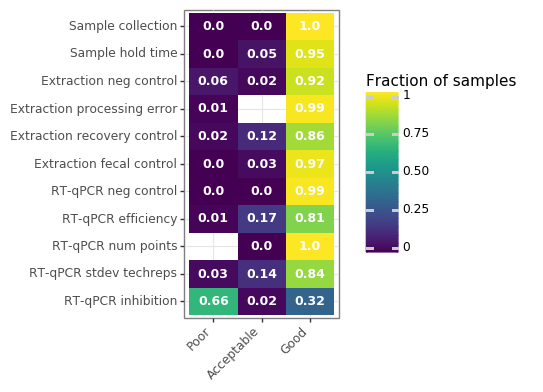

<ggplot: (308278889)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 4 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/quality_score_summary_no_missing_heatmap.png


In [28]:
plt = (ggplot(quality_info_agg, aes(x='value', y='variable', fill='Fraction of samples'))+
 geom_tile()+
 geom_text(aes(label='Fraction of samples'), size=9, color='white', fontweight='bold')+
 xlab('')+
 ylab('')+
 theme_bw()+
 theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(2, 4)))

display(plt)
ggsave(plt, f'{parent_dir}/quality_score_summary_no_missing_heatmap.png')

## How many samples had amplification in extraction blanks?

In [29]:
display(qpcr_processed[(qpcr_processed.Sample.str.contains('control_control_PBS')) &
               (qpcr_processed.Target == 'N1')].shape)

qpcr_processed[(qpcr_processed.Sample.str.contains('control_control_PBS')) &
               (qpcr_processed.Target == 'N1') &
               (qpcr_processed.detected_of_3_TechReps > 1)].shape

(249, 20)

(4, 20)

In [30]:
display(qpcr_processed[(qpcr_processed.Sample.str.contains('control_control_PBS')) &
               (qpcr_processed.Target == 'PMMoV')].shape)

qpcr_processed[(qpcr_processed.Sample.str.contains('control_control_PBS')) &
               (qpcr_processed.Target == 'PMMoV') &
               (qpcr_processed.detected_of_3_TechReps > 1)].shape

(239, 20)

(62, 20)

In [31]:
pmmov_ext_amp = qpcr_processed[(qpcr_processed.Sample.str.contains('control_control_PBS')) &
               (qpcr_processed.Target == 'PMMoV') &
               (qpcr_processed.detected_of_3_TechReps > 1)].copy()
pmmov_ext_amp['Cq_mean'] = pmmov_ext_amp.Cq.apply(np.nanmean)
pmmov_ext_amp.Cq_mean.median()

37.690185400000004

In [32]:
pmmov_samples = qpcr_processed[(~qpcr_processed.Sample.str.contains('control')) &
                               (qpcr_processed.Target == 'PMMoV')].copy()
pmmov_samples['Cq_mean'] = pmmov_samples.Cq.apply(np.nanmean)

display(pmmov_samples.Cq_mean.median())
display(len(pmmov_samples))

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:4200: RuntimeWarning: Mean of empty slice


28.431465493333334

2175

## Figure S4. PMMoV concentration distribution.

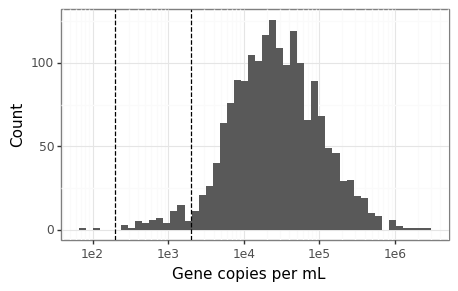

<ggplot: (309529365)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 3 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/pmmov_histogram.png


In [33]:
pmmov_run = n1_df_scored[(n1_df_scored.date_sampling >= '2020-11-13') &
                           (~n1_df_scored.pmmov_gc_per_mL.isna())
                          ].copy()
plt = (ggplot(pmmov_run, aes(x='pmmov_gc_per_mL'))+
geom_histogram(bins=50)+
ylab('Count')+
xlab('Gene copies per mL')+
theme_bw()+
theme(figure_size=(5,3))+
scale_x_log10()+
geom_vline(xintercept=2e3, linetype='dashed')+   
geom_vline(xintercept=2e2, linetype='dashed'))

display(plt)
ggsave(plt, f'{parent_dir}/pmmov_histogram.png')

In [34]:
pmmov_run.shape

(1802, 107)

## Figure S5. Bovine coronavirus recovery efficiency.

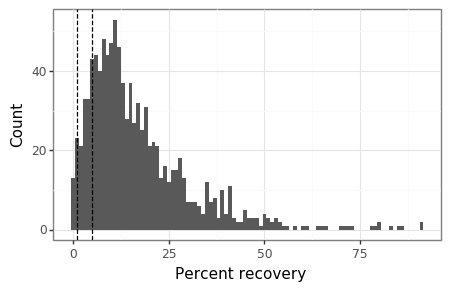

<ggplot: (308801905)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 3 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/bcov_recovery_histogram.png


In [35]:
recovery = n1_df_scored[['Sample','sample_code', 'date_sampling', 'bCoV_perc_recovered', 'sample_level', 'bCoV_spike_tube']].dropna().copy()
bad_spikes = ['JC', 'AC', 'AE', 'AK', 'GA', 'GB', 'GC', 'GD', 'EM', 'RA', 'RI', 'RJ', 'SL']
recovery = recovery[(~recovery.bCoV_spike_tube.isin(bad_spikes)) &
                    (recovery.date_sampling >= '2020-11-13')]

plt = (ggplot(recovery, aes(x='bCoV_perc_recovered'))+
geom_histogram(binwidth=1, center=1)+
geom_vline(xintercept=1.0, linetype='dashed')+
geom_vline(xintercept=5, linetype='dashed')+
ylab('Count')+
xlab('Percent recovery')+
theme_bw()+
theme(figure_size=(5,3)))
display(plt)
ggsave(plt, f'{parent_dir}/bcov_recovery_histogram.png')

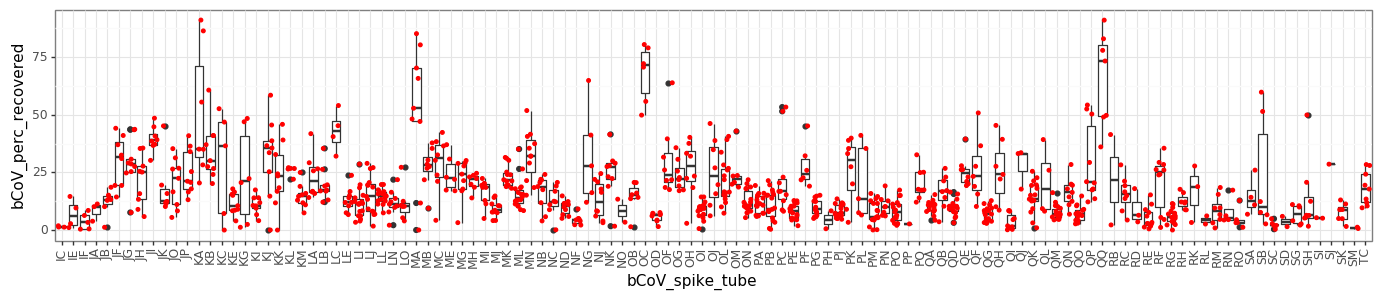

<ggplot: (308195145)>

In [36]:
plt = (ggplot(recovery, aes(x='bCoV_spike_tube', y='bCoV_perc_recovered'))+
geom_boxplot()+
geom_jitter(size=1, color='red')+
theme_bw()+
theme(axis_text_x=element_text(rotation=90, hjust=1.1), figure_size=(17,3)))
display(plt)

## Figure S6. Standard deviation of qPCR triplicates

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 38'. Pick better value with 'binwidth'.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 3 rows containing non-finite values.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


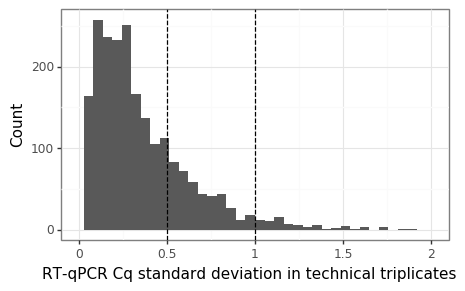

<ggplot: (306725677)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 3 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/std_qpcr_reps_histogram.png
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 38'. Pick better value with 'binwidth'.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 3 rows containing non-finite values.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


In [37]:
n1_df_scored['Cq_std'] = n1_df_scored.Cq_no_outliers.apply(np.nanstd)

plt = (ggplot(n1_df_scored[(~n1_df_scored.Cq_std.isna()) & (n1_df_scored.detected_of_3_TechReps == 3)], aes(x='Cq_std'))+
geom_histogram()+
geom_vline(xintercept=1, linetype='dashed')+
geom_vline(xintercept=0.5, linetype='dashed')+
theme_bw()+
xlim(0,2)+
ylab('Count')+
xlab('RT-qPCR Cq standard deviation in technical triplicates')+
#scale_x_log10()+
theme(figure_size=(5,3)))
display(plt)
ggsave(plt, f'{parent_dir}/std_qpcr_reps_histogram.png')

# Inhibition Analysis

In [38]:
qpcr_processed[qpcr_processed.ratio5x_1x > 5].shape

(33, 20)

In [39]:
qpcr_processed[(~qpcr_processed.ratio5x_1x.isna()) & (qpcr_processed.Target == 'N1')].shape

(1349, 20)

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 33 rows containing non-finite values.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


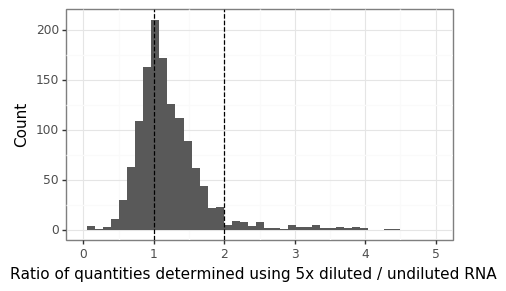

<ggplot: (307663457)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 3 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/inhibition_histogram.png
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 33 rows containing non-finite values.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


In [40]:
plt = (ggplot(qpcr_processed[(~qpcr_processed.ratio5x_1x.isna()) & (qpcr_processed.Target == 'N1')], aes(x='ratio5x_1x'))+
 geom_histogram(bins=45)+
 xlim(0, 5)+
 geom_vline(xintercept=1, linetype='dashed')+
 geom_vline(xintercept=2, linetype='dashed')+
 xlab('Ratio of quantities determined using 5x diluted / undiluted RNA')+
 ylab('Count')+
 theme_bw()+
 theme(figure_size=(5,3)))

display(plt)
ggsave(plt, f'{parent_dir}/inhibition_histogram.png')

In [41]:
# calculate xeno inhibition for plates with Xeno (48 plates)
qpcr_raw_df = read_qpcr_data(None, None, qpcr)
plates_with_xeno = qpcr_raw_df[qpcr_raw_df.Target == 'Xeno'].plate_id.unique()

# if the difference in Cq between Xeno in water (NTC) and Xeno in sample is greater than this cut-off, then there was inhibition
dCt_cutoff=1

xeno_inhibition_df = []

for plate_id in plates_with_xeno:
    # find the mean Cq (of triplicates) for Xeno in the no-template control (NTC)
    xeno_ntc_Cq_mean = np.nan
    xeno_ntc = plate_target_info_all[(plate_target_info_all.plate_id == plate_id) & (plate_target_info_all.Target == 'Xeno')]
    
    # skip if there is no NTC with Xeno
    if (len(xeno_ntc) > 0) and (~xeno_ntc.ntc_Cq.isna().all()): 
        xeno_ntc_Cq_mean = xeno_ntc.ntc_Cq.values[0]

    # filter the raw data for the rows where the target was Xeno on the plate of interest
    qpcr_processed_dilutions_xeno = qpcr_processed_dilutions[(qpcr_processed_dilutions.Target == 'Xeno') &
                                                           (qpcr_processed_dilutions.plate_id == plate_id)].copy()
    
    # compare the Cq of each sample row to the Cq of Xeno in the NTC
    qpcr_processed_dilutions_xeno['Cq_mean'] = qpcr_processed_dilutions_xeno.Cq_no_outliers.apply(np.nanmean)
    qpcr_processed_dilutions_xeno['xeno_dCt'] = qpcr_processed_dilutions_xeno.Cq_mean - xeno_ntc_Cq_mean
    
    # determine whether the sample was inhibited based on the dCt_cutoff specified above
    qpcr_processed_dilutions_xeno['is_inhibited_xeno'] = None
    qpcr_processed_dilutions_xeno.loc[qpcr_processed_dilutions_xeno.xeno_dCt >= dCt_cutoff, 'is_inhibited_xeno'] = True
    qpcr_processed_dilutions_xeno.loc[qpcr_processed_dilutions_xeno.xeno_dCt < dCt_cutoff, 'is_inhibited_xeno'] = False
    
    # save results
    result = qpcr_processed_dilutions_xeno[['Sample', 'dilution', 'xeno_dCt', 'is_inhibited_xeno', 'plate_id']]
    xeno_inhibition_df.append(result)
    
xeno_inhibition_df = pd.concat(xeno_inhibition_df)

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:4200: RuntimeWarning: Mean of empty slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:4200: RuntimeWarning: Mean of empty slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:4200: RuntimeWarning: Mean of empty slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:4200: RuntimeWarning: Mean of empty slice


In [42]:
# merge xeno inhibition info back onto the processed N1 data with 1x and 5x dilutions included
qpcr_processed_dilutions_N1 = qpcr_processed_dilutions[qpcr_processed_dilutions.Target == 'N1']
qpcr_processed_dilutions_N1 = qpcr_processed_dilutions_N1.merge(xeno_inhibition_df, how='left', on=['Sample', 'dilution', 'plate_id'])

In [43]:
qpcr_processed_dilutions_N1['Quantity_mean_undiluted'] = qpcr_processed_dilutions_N1['Quantity_mean'] * qpcr_processed_dilutions_N1['dilution']
qpcr_processed_dilutions_N1 = qpcr_processed_dilutions_N1[['Sample', 'dilution', 'Target', 'nondetect_count',
                                                           'Quantity_mean_undiluted', 'is_inhibited_xeno']].copy()
qpcr_processed_dilutions_N1 = qpcr_processed_dilutions_N1[~qpcr_processed_dilutions_N1.duplicated(subset=['Sample', 'dilution', 'Target'],
                                                                                                  keep='first')] #drop the first duplicate for duplicates
df_1 = qpcr_processed_dilutions_N1[qpcr_processed_dilutions_N1.dilution == 1].drop(columns='dilution') # get just 1x dilutions
df_5 = qpcr_processed_dilutions_N1[qpcr_processed_dilutions_N1.dilution == 5].drop(columns='dilution') # get just 5x dilutions
df_1_5 = df_1.merge(df_5, how='inner', on=['Sample', 'Target'], suffixes=['_1x', '_5x']) # merge back together adding "_1x" or "_5x" to column names
df_1_5 = df_1_5[~df_1_5.Sample.str.contains('control')]

df_1_5['ratio5x_to_1x'] = np.nan
df_1_5['ratio5x_to_1x'] = df_1_5.Quantity_mean_undiluted_5x / df_1_5.Quantity_mean_undiluted_1x
df_1_5 = df_1_5[df_1_5.Target == 'N1']

# merge with sample data and plate_target info
df_1_5 = df_1_5.merge(extraction_df, how = 'left', left_on = 'Sample', right_on = 'sample_id')

In [44]:
# remove non-detects at 1x or 5x (require that all 3 were detects)
df_filt = df_1_5[(df_1_5.nondetect_count_1x == 0) & 
                 (df_1_5.nondetect_count_5x == 0) &
                 (df_1_5.ratio5x_to_1x != 5.0)] # remove substituted 1/2 LoD values that will default to exactly 5.0

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


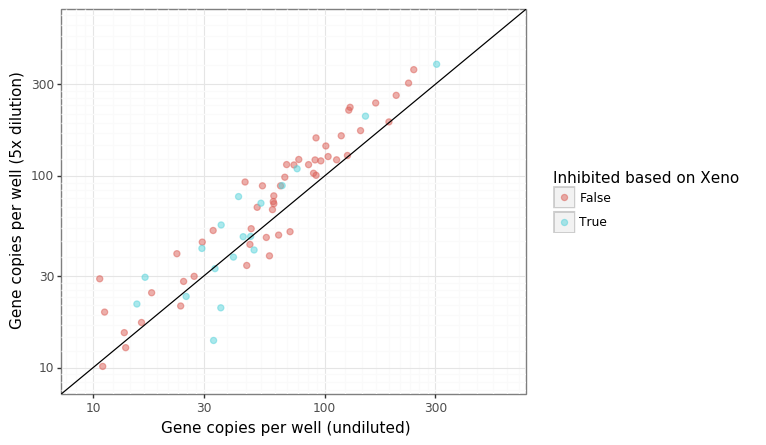

<ggplot: (309452637)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 5 in image.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/rosekantor/scientific_work/Nelson_lab/wbe_project/writeups/blueprint_paper/figures/inhibition_xeno_vs_dilution.png
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


In [45]:
df_filt_xeno = df_filt[(~pd.isnull(df_filt.is_inhibited_xeno_1x)) & (~pd.isnull(df_filt.is_inhibited_xeno_5x))].copy()

plt = (ggplot(df_filt_xeno, aes(x='Quantity_mean_undiluted_1x', y='Quantity_mean_undiluted_5x', color='is_inhibited_xeno_1x'))+ 
 geom_point(size=2, alpha=0.5)+
 scale_y_log10(limits=(9,600))+
 scale_x_log10(limits=(9,600))+
 xlab('Gene copies per well (undiluted)')+
 ylab('Gene copies per well (5x dilution)')+
 labs(color='Inhibited based on Xeno')+
 geom_abline(slope=1, intercept=0)+
 theme_bw()+
 theme(figure_size=(6,5))
 )

display(plt)
ggsave(plt, f'{parent_dir}/inhibition_xeno_vs_dilution.png')

## Figure S8 and S9. RT-qPCR efficiency and y-intercept by technician.

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 26 rows containing missing values.


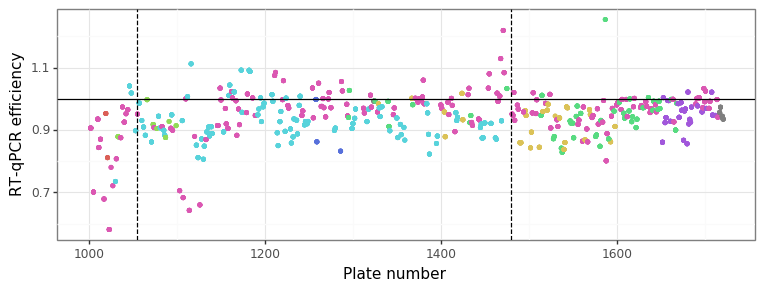

<ggplot: (308802061)>

In [46]:
(ggplot(n1_df_scored, aes(x='plate_id', y='efficiency', color='run_by'))+
 geom_point(show_legend=False, size=1)+
 geom_hline(yintercept=1)+
 geom_vline(xintercept=1054, linetype='dashed')+
 geom_vline(xintercept=1480, linetype='dashed')+
 xlim(1000,n1_df_scored.plate_id.max())+
 ylab('RT-qPCR efficiency')+
 xlab('Plate number')+
 theme_bw()+
 theme(figure_size=(9,3)))

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


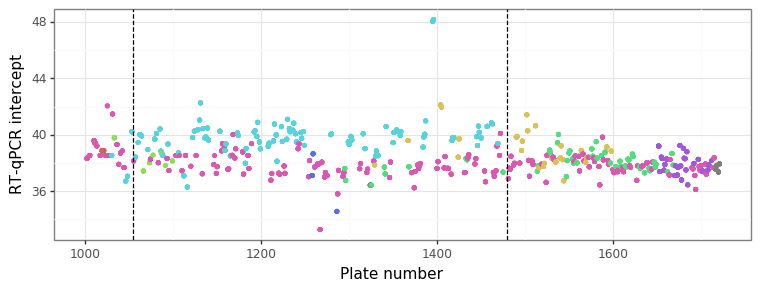

<ggplot: (309695701)>

In [47]:
(ggplot(n1_df_scored, aes(x='plate_id', y='intercept', color='run_by'))+
 geom_point(show_legend=False, size=1)+
 geom_vline(xintercept=1054, linetype='dashed')+
 geom_vline(xintercept=1480, linetype='dashed')+
 xlim(1000,n1_df_scored.plate_id.max())+
 ylab('RT-qPCR intercept')+
 xlab('Plate number')+
 theme_bw()+
 theme(figure_size=(9,3)))

## Hold time

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 501 rows containing non-finite values.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


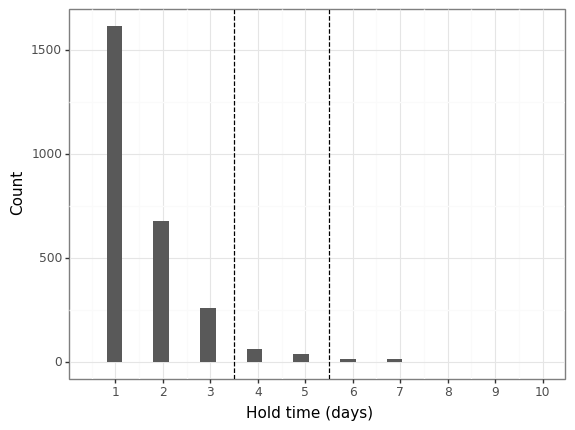

<ggplot: (308175093)>

In [48]:
n1_df_scored['hold_time'] = (n1_df_scored.date_extract - n1_df_scored.date_sampling).dt.days
n1_df_scored.loc[n1_df_scored.hold_time < 0, 'hold_time'] = np.nan

plt = (ggplot(n1_df_scored[n1_df_scored.date_sampling >= '2020-10-01'][['hold_time']], aes(x='hold_time'))+
 geom_histogram()+
 #xlim(0,10)+
 scale_x_continuous(limits=(0.5,10), breaks=list(range(1,11)))+
 geom_vline(xintercept = 3.5, linetype='dashed')+
 geom_vline(xintercept = 5.5, linetype='dashed')+
 xlab('Hold time (days)')+
 ylab('Count')+
 theme_bw())
display(plt)

In [49]:
n1_df_scored['hold_time'].median()

1.0

## Turnaround time

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 118 rows containing non-finite values.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


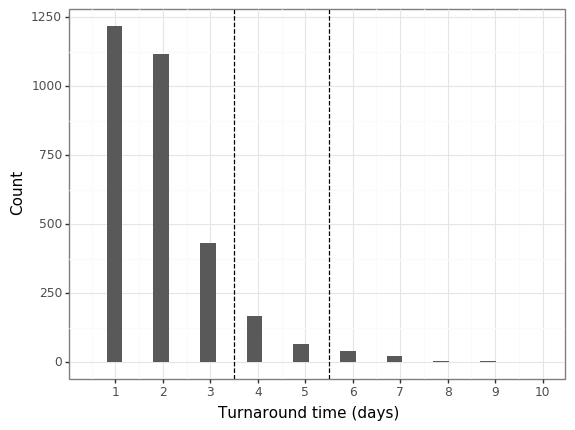

<ggplot: (308165949)>

In [50]:
n1_df_scored['turnaround_time'] = (n1_df_scored.plate_date - n1_df_scored.date_sampling).dt.days

plt = (ggplot(n1_df_scored[n1_df_scored.date_sampling >= '2020-10-01'], aes(x='turnaround_time'))+
 geom_histogram()+
 #xlim(0,10)+
 scale_x_continuous(limits=(0.5,10), breaks=list(range(1,11)))+
 geom_vline(xintercept = 3.5, linetype='dashed')+
 geom_vline(xintercept = 5.5, linetype='dashed')+
 xlab('Turnaround time (days)')+
 ylab('Count')+
 theme_bw())
display(plt)

In [51]:
n1_df_scored[n1_df_scored.date_sampling > '2021-05-01'].turnaround_time.mean()

1.796641791044776

In [52]:
len(n1_df_scored[n1_df_scored.turnaround_time <= 2]) / len(n1_df_scored)

0.7523664122137405